# Modeling the Fire Data for Fires Over 1 Acre and Lasting Longer than 24 Hours

## Focusing on Removing Outliers and Polynomial Features

In [206]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ridge_regression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.cluster import DBSCAN

In [250]:
np.random.seed(42)

df = pd.read_csv('../../data/processed/master_dataset.csv')

df.head()

,sum_rain,sum_snow,DiscoveryAcres,total_acres,temp_2m,temp_2m_max,humidity,rain,wind_speed_2m,wind_speed_2m_max,wind_speed_10m,wind_speed_10m_max,surface_soil_wetness_5cm_below,surface_soil_wetness_to_bedrock,landcover_class
0,158.20,2.64,5.0,5990.90,24.80,33.19,5.92,0.00,1.76,3.42,2.61,4.52,0.31,0.37,489
1,10.54,0.00,1.0,136.00,22.72,31.95,2.69,0.00,2.65,4.88,3.88,6.57,0.12,0.42,470
2,152.93,2.64,15.0,147.00,26.21,35.48,7.57,0.01,1.62,4.30,2.66,6.88,0.29,0.38,183
3,284.77,7.83,1.0,2.88,-0.55,3.97,2.14,0.00,0.06,0.10,5.79,7.85,0.63,0.62,163
4,395.50,4.62,0.1,13.10,22.30,32.40,8.00,0.00,0.16,0.45,1.83,3.48,0.40,0.48,301


In [251]:
for i in df.columns:
    print(i)

sum_rain
sum_snow
DiscoveryAcres
total_acres
temp_2m
temp_2m_max
humidity
rain
wind_speed_2m
wind_speed_2m_max
wind_speed_10m
wind_speed_10m_max
surface_soil_wetness_5cm_below
surface_soil_wetness_to_bedrock
landcover_class


In [252]:
df.shape

(2122, 15)

In [253]:
df['total_acres'].describe()

count      2122.000000
mean       2999.687916
std       21287.395283
min           1.170000
25%           4.600000
50%          19.100000
75%         158.950000
max      413718.000000
Name: total_acres, dtype: float64

In [254]:
iqr = 158.95-4.6
upper_range = 1.5*iqr + 158.95
df = df[df['total_acres'] <= upper_range]

In [255]:
df.shape

(1724, 15)

---
######
### Investigating Clustering:
######
##### Using DBSCAN and Potentially Adding Cluster Results as Feature
######
___

In [256]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'total_acres'), df['total_acres'], random_state= 42)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [257]:
# Checking to see which value of epsilon is best

silhouette_score_list = []
epsilons = np.linspace(1, 10, 20)

for i in epsilons:
    try:
        dbscan = DBSCAN(eps=i)
        dbscan.fit(X_train)
        silhouette_score_list.append([silhouette_score(X_train, dbscan.labels_), i])
    except:
        pass
silhouette_score_list

[[-0.3602412959172937, 1.0],
 [-0.27127586688691074, 1.4736842105263157],
 [0.25630971921938606, 1.9473684210526314],
 [0.38298188987525206, 2.4210526315789473],
 [0.49147603827925496, 2.894736842105263],
 [0.5008692311004035, 3.3684210526315788],
 [0.5456956757682443, 3.8421052631578947],
 [0.5795107952760772, 4.315789473684211],
 [0.679444527582705, 4.789473684210526],
 [0.7300696979411784, 5.263157894736842],
 [0.7300696979411784, 5.7368421052631575],
 [0.7300696979411784, 6.2105263157894735],
 [0.8004412350233295, 6.684210526315789],
 [0.8004412350233295, 7.157894736842105],
 [0.8004412350233295, 7.63157894736842],
 [0.8004412350233295, 8.105263157894736],
 [0.8004412350233295, 8.578947368421051],
 [0.8004412350233295, 9.052631578947368],
 [0.8004412350233295, 9.526315789473683],
 [0.8004412350233295, 10.0]]

In [258]:
#checking to see 
silhouette_score_list = []
min_samples = range(1, 21)

for j in min_samples:
    try:
        dbscan = DBSCAN(eps= 6.47, min_samples = j)
        dbscan.fit(X_train)
        silhouette_score_list.append([silhouette_score(X_train, dbscan.labels_), j])
    except:
        pass
silhouette_score_list

[[0.8004412350233295, 1],
 [0.8004412350233295, 2],
 [0.8004412350233295, 3],
 [0.8004412350233295, 4],
 [0.8004412350233295, 5],
 [0.8004412350233295, 6],
 [0.8004412350233295, 7],
 [0.8004412350233295, 8],
 [0.8004412350233295, 9],
 [0.8004412350233295, 10],
 [0.8004412350233295, 11],
 [0.8004412350233295, 12],
 [0.7300696979411784, 13],
 [0.7300696979411784, 14],
 [0.7300696979411784, 15],
 [0.7300696979411784, 16],
 [0.7300696979411784, 17],
 [0.7300696979411784, 18],
 [0.7300696979411784, 19],
 [0.7300696979411784, 20]]

In [259]:
db = DBSCAN(eps=6.68)
db.fit(X_train)
pd.Series(db.labels_).unique()

array([ 0, -1], dtype=int64)

In [260]:
(db.labels_ == -1).sum()

1

Decided to not use DBSCAN

---
######
### Investigating Correlation Between the Features and Target (DailyAcres)
######
___

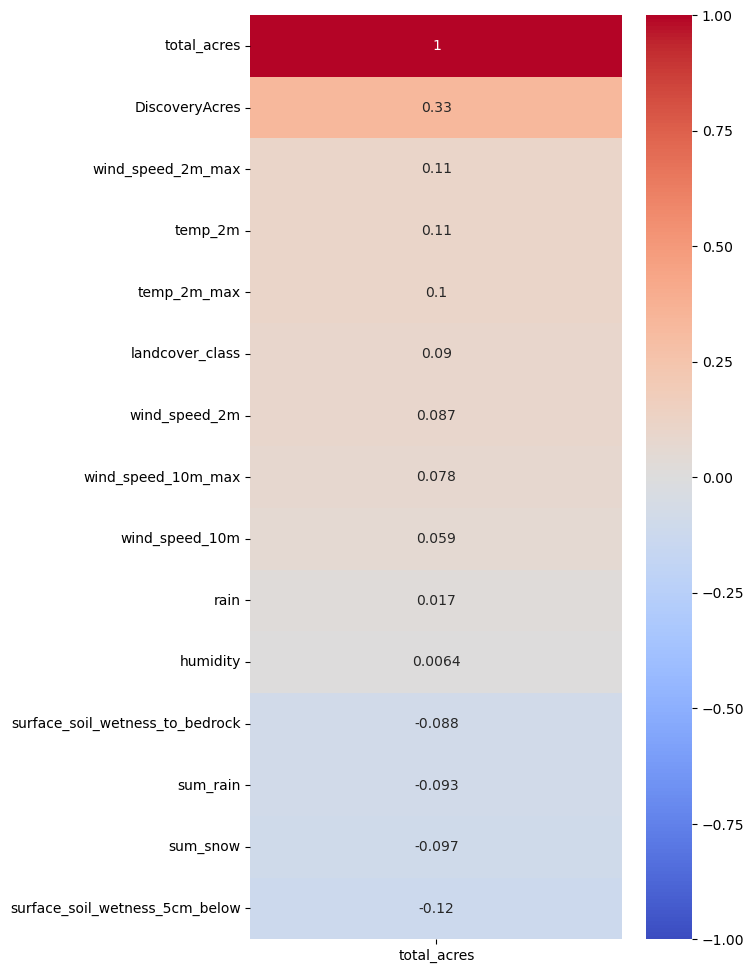

In [261]:
plt.figure(figsize = (6, 12))
sns.heatmap(df.corr()[['total_acres']].sort_values(by = 'total_acres', ascending=False),
            vmin = -1,
            vmax = 1, 
            cmap = 'coolwarm',
            annot = True);

---
######
### Train/Test Splitting Data, Standard Scaling, Polynomial Features and PCA (not using landcover_class)
######
___

In [262]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['total_acres', 'landcover_class']), df['total_acres'], random_state= 42)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [263]:
poly = PolynomialFeatures()
poly_X_train = poly.fit_transform(X_train_sc)
poly_X_test = poly.transform(X_test_sc)

In [264]:
poly_X_train.shape

(1293, 105)

In [265]:
pca = PCA(random_state = 42)


Z_train_poly = pca.fit_transform(poly_X_train)
Z_test_poly = pca.transform(poly_X_test)

In [266]:
explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)
np.round(cumulative[:60], 3)

array([0.553, 0.651, 0.745, 0.808, 0.837, 0.858, 0.876, 0.894, 0.906,
       0.917, 0.925, 0.931, 0.937, 0.942, 0.947, 0.951, 0.955, 0.958,
       0.961, 0.964, 0.967, 0.969, 0.971, 0.974, 0.976, 0.977, 0.979,
       0.981, 0.982, 0.983, 0.985, 0.986, 0.987, 0.988, 0.989, 0.989,
       0.99 , 0.991, 0.992, 0.992, 0.993, 0.993, 0.994, 0.994, 0.995,
       0.995, 0.995, 0.996, 0.996, 0.996, 0.997, 0.997, 0.997, 0.997,
       0.998, 0.998, 0.998, 0.998, 0.998, 0.998])

In [267]:
Z_train_poly = Z_train_poly[:,:60]
Z_test_poly = Z_test_poly[:,:60]

In [269]:
# PCA X_train without Polynomial Feature transformation
pca = PCA(random_state = 42)


Z_train = pca.fit_transform(X_train_sc)
Z_test = pca.transform(X_test_sc)

In [270]:
explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)
np.round(cumulative[:12], 3)

array([0.333, 0.557, 0.679, 0.769, 0.846, 0.906, 0.937, 0.964, 0.98 ,
       0.991, 0.999, 1.   ])

In [271]:
Z_train = Z_train[:,:12]
Z_test = Z_test[:,:12]

---
######
### Dummying Landcover_Class and re-train/test splitting
######
___

In [272]:
df1 = pd.get_dummies(data = df, columns = ['landcover_class'], drop_first= True)
X_train_dum, X_test_dum, y_train, y_test = train_test_split(df1.drop(columns = ['total_acres']), df['total_acres'], random_state= 42)
ss = StandardScaler()
X_train_dum = ss.fit_transform(X_train_dum)
X_test_dum = ss.transform(X_test_dum)

In [111]:
#np.savetxt('../../data/processed/Neural_Net_Data/X_train_without_outliers.csv', X_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/X_test_without_outliers.csv', X_test, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/Z_train_without_outliers.csv', Z_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/Z_test_without_outliers.csv', Z_test, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/Z_train_poly_without_outliers.csv', Z_train_poly, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/Z_test_poly_without_outliers.csv', Z_test_poly, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/y_train_without_outliers.csv', y_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/y_test_without_outliers.csv', y_test, delimiter=',')

---
######
### Modeling / Simple Models
######
---

#### Linear Regression (Baseline) with DF including Landcover_class Dummied Columns

In [276]:
#Linear Regression - Baseline
# With X data
lr = LinearRegression()

lr.fit(X_train_dum, y_train)
print(f'Training R-Squared: {lr.score(X_train_dum, y_train)}')
print(f'Testing R-Squared: {lr.score(X_test_dum, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(X_test_dum), squared = False)}')

Training R-Squared: 0.19686113693084284
Testing R-Squared: -1.2354481655103512e+22
RMSE: 7737854684080.361


#### Linear Regression (Baseline) with DF without Landcover_class Dummied Columns

In [275]:
lr = LinearRegression()

lr.fit(X_train, y_train)
print(f'Training R-Squared: {lr.score(X_train, y_train)}')
print(f'Testing R-Squared: {lr.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(X_test), squared = False)}')

Training R-Squared: 0.11707479932695453
Testing R-Squared: 0.18276676904241673
RMSE: 62.933417201762055


#### Linear Regression (Baseline) with Polynomial PCA

In [277]:
#Linear Regression - Baseline
# With PCA Data
lr = LinearRegression()

lr.fit(Z_train_poly, y_train)
print(f'Training R-Squared: {lr.score(Z_train_poly, y_train)}')
print(f'Testing R-Squared: {lr.score(Z_test_poly, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(Z_test_poly), squared = False)}')

Training R-Squared: 0.16205695441889467
Testing R-Squared: 0.1953926007692225
RMSE: 62.44538047448781


#### Linear Regression (Baseline) with PCA (w/o Polynomial Tranformation)

In [278]:
#Linear Regression - Baseline
# With PCA Data
lr = LinearRegression()

lr.fit(Z_train, y_train)
print(f'Training R-Squared: {lr.score(Z_train, y_train)}')
print(f'Testing R-Squared: {lr.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(Z_test), squared = False)}')

Training R-Squared: 0.11046452897439385
Testing R-Squared: 0.19061004382028424
RMSE: 62.63069203984553


In [279]:
def model_eval(model, param_dict, training_data):
    '''
    d
    '''
    
    gs_model = GridSearchCV(model,
                            param_grid = param_dict,
                            n_jobs = -1)
    if training_data == 'X_train':
        training = X_train
        testing = X_test
    elif training_data == 'X_test_dum':
        training = X_train_dum
        testing = X_test_dum
    elif training_data == 'Z_train':
        training = Z_train
        testing = Z_test
    elif training_data == 'Z_train_poly':
        training = Z_train_poly
        testing = Z_test_poly
    else:
        return "Mistaken Training Data Parameter"
    
    gs_model.fit(training, y_train)
    print(f'Best Score: {gs_model.best_score_}')
    print(f'Best Params: {gs_model.best_params_}')
    print('='*50)
    print(f'RMSE: {mean_squared_error(y_test, gs_model.predict(testing), squared = False)}')
    print('='*50)
    print(f'Training R-Squared: {gs_model.score(training, y_train)}')
    print(f'Testing R-Squared: {gs_model.score(testing, y_test)}')

#### KNN Regression with DF

In [280]:
#KNN Regressor with X Data

knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(10, 201, 10),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'X_train')

Best Score: 0.031367700477482184
Best Params: {'n_neighbors': 60, 'weights': 'distance'}
RMSE: 66.06886360974818
Training R-Squared: 0.9987297075671161
Testing R-Squared: 0.09930642687869062


#### KNN Regression with PCA Data

In [188]:
#KNN Regressor with PCA Data

knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(10, 201, 10),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'Z_train')

Best Score: 0.036062819203705174
Best Params: {'n_neighbors': 80, 'weights': 'distance'}
RMSE: 65.87368784043143
Training R-Squared: 0.9987298175367992
Testing R-Squared: 0.1046200918418454


#### Lasso Regression with DF

In [189]:
# Lasso Regression with X Data

lasso = Lasso()
lasso_params = {
    'alpha': range(1, 101, 2)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'X_train')

Best Score: 0.08794250566148398
Best Params: {'alpha': 3}
RMSE: 63.128277369729574
Training R-Squared: 0.14186227155029252
Testing R-Squared: 0.1776981505553541


#### Lasso Regression with PCA

In [190]:
# Lasso Regression with PCA Data

lasso = Lasso()
lasso_params = {
    'alpha': range(1, 101, 2)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'Z_train')

Best Score: 0.04571182104853688
Best Params: {'alpha': 1}
RMSE: 63.35190593955067
Training R-Squared: 0.145446157778379
Testing R-Squared: 0.1718619102890997


#### Adaboost Regression with DF

In [191]:
# Adaboost with X Data

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(40, 101, 10),
    'learning_rate': [0.5, 0.75, 1, 1.25, 1.5] 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'X_train')

Best Score: -0.41346246922933966
Best Params: {'learning_rate': 0.5, 'n_estimators': 50}
RMSE: 82.13474231333184
Training R-Squared: -0.26253698490122623
Testing R-Squared: -0.39199343743915094


#### Adaboost Regression with PCA

In [192]:
# Adaboost with PCA Data

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(40, 101, 10),
    'learning_rate': [0.5, 0.75, 1, 1.25, 1.5] 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'Z_train')

Best Score: -0.26883412248766725
Best Params: {'learning_rate': 0.5, 'n_estimators': 40}
RMSE: 77.11398444703974
Training R-Squared: -0.009570497770514885
Testing R-Squared: -0.22701444916170987


#### RandomForest Regression with DF

In [121]:
# Random Forest with X_train

rf = RandomForestRegressor(n_jobs = -1)

rf_params = {
    'max_depth': range(70, 201, 10),
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'ccp_alpha': [0.01, 0.1, 0.5, 1]
}

model_eval(model = rf,
           param_dict = rf_params,
           training_data = 'X_train')

Best Score: 0.06589457070466445
Best Params: {'ccp_alpha': 0.01, 'max_depth': 70, 'min_samples_leaf': 2, 'min_samples_split': 3}
RMSE: 63.65811634772471
Training R-Squared: 0.7513843325367814
Testing R-Squared: 0.1638369788528159


#### RandomForest Regression with PCA

In [122]:
# Random Forest with PCA

rf = RandomForestRegressor(n_jobs = -1)

rf_params = {
    'max_depth': range(70, 201, 10),
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'ccp_alpha': [0.01, 0.1, 0.5, 1]
}

model_eval(model = rf,
           param_dict = rf_params,
           training_data = 'Z_train')

Best Score: 0.029998642937097177
Best Params: {'ccp_alpha': 0.5, 'max_depth': 80, 'min_samples_leaf': 3, 'min_samples_split': 3}
RMSE: 63.47466833481446
Training R-Squared: 0.7290090398739548
Testing R-Squared: 0.16864929290350972


---
######
### Modeling / Ensemble Models
######
---

#### Stacking Regression with DF and with DecisionTreeRegressor Final Estimator

In [193]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=DecisionTreeRegressor(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: -1.4184027880954284
Testing R-Squared: -1.5735150418438275
RMSE: 111.67903703281885


#### Stacking Regression with PCA and with DecisionTreeRegressor Final Estimator

In [194]:
# Stacking Regressor with Z_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=DecisionTreeRegressor(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: -0.8380928393433082
Testing R-Squared: -1.2700805059093656
RMSE: 104.8887560079958


#### Stacking Regression with DF and with LinearRegression Final Estimator

In [195]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: 0.35317341766092314
Testing R-Squared: 0.1685160144615857
RMSE: 63.47975611894257


#### Stacking Regression with PCA and with LinearRegression Final Estimator

In [196]:
# Stacking Regressor with PCA

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.36721870432456305
Testing R-Squared: 0.15260315049160966
RMSE: 64.08431220679155


#### Stacking Regression with DF and with Lasso Final Estimator

In [197]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: 0.39146410560561584
Testing R-Squared: 0.16778479473900154
RMSE: 63.507662518737


#### Stacking Regression with PCA and with Lasso Final Estimator

In [198]:
# Stacking Regressor with PCA

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.3774795148457408
Testing R-Squared: 0.15092702302086747
RMSE: 64.14765939379238


#### Stacking Regression (different base estimators) with DF and with Lasso Final Estimator

In [199]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: 0.15643391122638106
Testing R-Squared: 0.15881909802574934
RMSE: 63.84883935062261


#### Stacking Regression (different base estimators) with PCA and with Lasso Final Estimator

In [200]:
# Stacking Regressor with PCA

lvl1_est = ([
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.16276340132215728
Testing R-Squared: 0.13456852641203
RMSE: 64.76265544789085


#### Voting Regression with DF

In [201]:
#Voting Classifier with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

vote = VotingRegressor(estimators = lvl1_est, n_jobs = -1)

vote.fit(X_train, y_train)
print(f'Training R-Squared: {vote.score(X_train, y_train)}')
print(f'Testing R-Squared: {vote.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, vote.predict(X_test), squared = False)}')

Training R-Squared: 0.2933529666480559
Testing R-Squared: -0.058279572429008164
RMSE: 71.61574458739382


#### Voting Regression with PCA

In [202]:
#Voting Classifier with PCA

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

vote = VotingRegressor(estimators = lvl1_est, n_jobs = -1)

vote.fit(Z_train, y_train)
print(f'Training R-Squared: {vote.score(Z_train, y_train)}')
print(f'Testing R-Squared: {vote.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, vote.predict(Z_test), squared = False)}')

Training R-Squared: 0.4248795769435958
Testing R-Squared: 0.019913983612345643
RMSE: 68.91922758976229
